In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from PIL import Image
import os
import cv2
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from skimage import exposure
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC

In [2]:
trainingDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/trainingDataAUG_HEM'
trainingDataHEM1 = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/trainingDataHEM'
trainingDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/trainingDataALL'

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.bmp')]

In [4]:
img_listHem = []
load_path = get_imlist(trainingDataHEM)
for i in load_path:
    image_array = np.array(Image.open(i))
    resized = exposure.equalize_adapthist(image_array,clip_limit=0.15,nbins=256)

    img_listHem.append(resized)

In [5]:
load_path = get_imlist(trainingDataHEM1)
for i in load_path:
    image_array = np.array(Image.open(i))
    resized = exposure.equalize_adapthist(image_array,clip_limit=0.15,nbins=256)

    img_listHem.append(resized)

In [6]:
img_listAll = []
load_path = get_imlist(trainingDataALL)
for i in load_path:
    image_array = np.array(Image.open(i))
    resized = exposure.equalize_adapthist(image_array,clip_limit=0.15,nbins=256)

    img_listAll.append(resized)

In [7]:
def imageResize(img,size):
    image_resizing = cv2.resize(np.array(img), (size, size), interpolation=cv2.INTER_LANCZOS4)
    image_resizing = image_resizing.astype(np.float32)
    return image_resizing

In [8]:
resized_Hem = []
for index, img in enumerate(img_listHem):
    img = imageResize(img,256)
    
    resized_Hem.append(img)

In [9]:
resized_ALL = []
for index, img in enumerate(img_listAll):
    img = imageResize(img,256)
    resized_ALL.append(img)

In [10]:
hem_label = [0 for i in range(0,4810)]
len(hem_label)

4810

In [11]:
all_label = [1 for i in range(0,4815)]
len(all_label)

4815

In [12]:
dataLabel = hem_label+all_label
dataLabel = np.array(dataLabel)

In [13]:
dataImage = resized_Hem + resized_ALL
dataImage = np.array(dataImage)

In [ ]:
dataImage = dataImage.astype(np.float32)

In [14]:
trainingData, trainingLabel, validationData, validationLabel = train_test_split(dataImage, dataLabel, test_size=0.25, random_state=42, stratify=dataLabel)

In [45]:
len(trainingData)

7218

In [17]:
trainingImage = trainingData.copy()
trainingLabels = validationData.copy()

In [19]:
ValidationImage = trainingLabel.copy()

In [21]:
augmentation = preprocessing.image.ImageDataGenerator()
augmentation.fit(trainingImage)

In [22]:
trainImage_generator = augmentation.flow(trainingImage,trainingLabels,batch_size=32)

In [43]:
augmentation.fit(ValidationImage)
validImage_generator = augmentation.flow(ValidationImage,validationLabel,batch_size=32)

In [49]:
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[AUC(name='auc')])
earlyStopping = EarlyStopping(monitor='val_auc', patience=5, verbose=1, mode='max')
history = model.fit(
    trainImage_generator,
    steps_per_epoch=floor(len(trainingImage)//32),
    epochs=100,
    validation_data=validImage_generator,
    validation_steps=floor(len(ValidationImage)//32),
    callbacks=[earlyStopping]
)

loss, accuracy = model.evaluate(validImage_generator,steps=floor(len(ValidationImage)//32))

Epoch 1/100
225/225 [==============================] - 582s 3s/step - loss: 0.5991 - auc: 0.7605 - val_loss: 0.4406 - val_auc: 0.9060
Epoch 2/100
225/225 [==============================] - 551s 2s/step - loss: 0.3453 - auc: 0.9207 - val_loss: 0.2958 - val_auc: 0.9455
Epoch 3/100
225/225 [==============================] - 548s 2s/step - loss: 0.2794 - auc: 0.9485 - val_loss: 0.2718 - val_auc: 0.9519
Epoch 4/100
225/225 [==============================] - 550s 2s/step - loss: 0.2370 - auc: 0.9621 - val_loss: 0.2910 - val_auc: 0.9505
Epoch 5/100
225/225 [==============================] - 549s 2s/step - loss: 0.2019 - auc: 0.9735 - val_loss: 0.2885 - val_auc: 0.9490
Epoch 6/100
225/225 [==============================] - 547s 2s/step - loss: 0.1659 - auc: 0.9828 - val_loss: 0.2726 - val_auc: 0.9571
Epoch 7/100
225/225 [==============================] - 544s 2s/step - loss: 0.1337 - auc: 0.9888 - val_loss: 0.3186 - val_auc: 0.9568
Epoch 8/100
225/225 [==============================] - 554s 2s

In [50]:
model.save('C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/models/balancedModelContrast.h5')

In [53]:
acc = history.history['auc']
val_acc = history.history['val_auc']
val_loss = history.history['val_loss']

In [54]:
epoch = range(1, len(acc)+1)

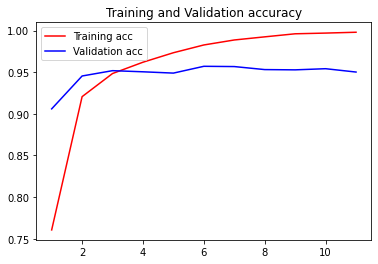

In [56]:
plt.plot(epoch, acc, 'r', label = 'Training acc')
plt.plot(epoch, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.show()

In [57]:
#Test data

In [58]:
testDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2/hem'
testDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/training_data/fold_2/all'